# Purpose

The purpose of this notebook is to create a model to predict drug resistance value from sequence.

- Sequence Feature Tested:
    - Amino acid pKa values
- Model:
    - Random Forest Regressor

In [1]:
# Jupyter notebook magic statements
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')

from Bio import SeqIO
from util.isoelectric_point import *  # imported from the 'util/' directory
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

/Users/ericmjl/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# List the files present in the "data" folder
! ls data/

20150902_nnet_ha.fasta                hiv-nnrt-data.csv                     hiv-protease-data-expanded.csv        hiv-protease.pdb
HIV-1_pol.fasta                       hiv-nrt-data.csv                      hiv-protease-data.csv                 hiv-rt-consensus.fasta
amino_acid_properties.csv             hiv-protease-consensus.fasta          hiv-protease-sequences-expanded.fasta


In [4]:
# Load the protease resistance data into memory.
# [ ] TODO: Refactor this function out as a load_data() function.
resistance = pd.read_csv('data/hiv-protease-data-expanded.csv', index_col=0)
drug_cols = ['NFV', 'SQV', 'FPV', 'IDV', 'LPV', 'ATV', 'TPV', 'DRV']
resistance.set_index('seqid', inplace=True)
resistance[drug_cols] = resistance[drug_cols].apply(np.log10)
resistance.head()

,ATV,DRV,FPV,IDV,LPV,NFV,SQV,SeqID,TPV,sequence,sequence_object,weight
seqid,,,,,,,,,,,,
2996-0,NaN,NaN,0.397940,1.212188,NaN,1.586587,1.206826,2996,NaN,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-0\nName: <unknown name>\nDescription:...,0.50
2996-1,NaN,NaN,0.397940,1.212188,NaN,1.586587,1.206826,2996,NaN,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-1\nName: <unknown name>\nDescription:...,0.50
4387-0,NaN,NaN,-0.154902,-0.096910,NaN,-0.096910,0.041393,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-0\nName: <unknown name>\nDescription:...,0.25
4387-1,NaN,NaN,-0.154902,-0.096910,NaN,-0.096910,0.041393,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-1\nName: <unknown name>\nDescription:...,0.25
4387-2,NaN,NaN,-0.154902,-0.096910,NaN,-0.096910,0.041393,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-2\nName: <unknown name>\nDescription:...,0.25


In [5]:
# Count the number of NaNs in each of the drug resistance columns.
pd.isnull(resistance[drug_cols]).sum().sort_values()

NFV     111
SQV     316
FPV     319
IDV     325
LPV     930
ATV    1928
TPV    2650
DRV    4141
dtype: int64

In [6]:
# Convert the FASTA file of sequences into a pandas dataframe.
# [ ] TODO: Refactor out into a load_sequences() function.
sequences = [np.array(s) for s in SeqIO.parse('data/hiv-protease-sequences-expanded.fasta', 'fasta')]
seqids = [s.id for s in SeqIO.parse('data/hiv-protease-sequences-expanded.fasta', 'fasta')]
sequences = pd.DataFrame(sequences)
sequences.index = seqids

# Because there's a lower-case character somewhere, force all of the characters to be upper-case.
for col in sequences.columns:
    sequences[col] = sequences[col].apply(lambda x: str(x).upper())

In [2]:
# Commands to inspect the utility scripts
# ! ls util/
! cat util/isoelectric_point.py

"""
Author: Eric J. Ma
Date: 2015-03-17
"""

isoelectric_points = {
    'A':6.11,
    'R':10.76,
    'N':10.76,
    'D':2.98,
    'C':5.02,
    'E':3.08,
    'Q':5.65,
    'G':6.06,
    'H':7.64,
    'I':6.04,
    'L':6.04,
    'K':9.74,
    'M':5.74,
    'F':5.91,
    'P':6.30,
    'S':5.68,
    'T':5.60,
    'W':5.88,
    'Y':5.63,
    'V':6.02,
    'X':7.00,  # unknown so assign neutral
    'B':6.87,  # the average of D and N
    'Z':4.35,  # the average of E and Q
    'J':6.04,  # the average of I and L
}

def get_isoelectric_point(aa):
    return isoelectric_points[aa]

In [8]:
# Replace the letters with amino acid pKas
# Also ensure that "*" are replace with NaN, which are then dropped later.
pKa_features = sequences.replace(isoelectric_points.keys(), isoelectric_points.values()).replace('*', np.nan)
# The command to join in any arbitrary drug resistance column is shown below.
# sequences.join(resistance['FPV'])

In [34]:
# Join in the resistance data for FPV

# Tunable parameters
X_cols = [i for i in range(0,99)]
drug = 'NFV'
weight_col = 'weight'

# Get the final data matrix, and split into X and Y
# Note: the .dropna() command is here because above we had to fill "*" with NaN, but could not yet drop the columns.
data_matrix = pKa_features.join(resistance[[drug, weight_col]]).dropna()
X = data_matrix[X_cols]
Y = data_matrix[drug]
W = data_matrix[weight_col]

# Perform a train/test split
cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Compute the following:
mdl = RandomForestRegressor(n_estimators=100)

# Compute the score as the mean absolute error
scores = cross_val_score(mdl, X, Y, cv=cv, scoring='mean_absolute_error', n_jobs=-1)
np.abs(np.mean(scores))

0.081523908693916278

In [35]:
# Do a fit/predict on the X and Y matrices.
mdl = RandomForestRegressor(n_estimators=100)
mdl.fit(X_train, Y_train, sample_weight=W.ix[X_train.index].values)
preds = mdl.predict(X_test)
score = mdl.score(X_test, Y_test)

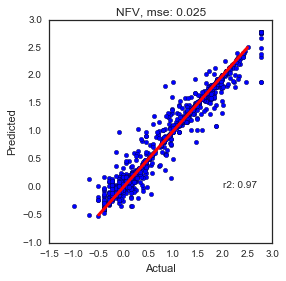

In [36]:
# Plot the predicted against actual.
fig = plt.figure(figsize=(4,4))
plt.scatter(Y_test, preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([-0.5,2.5], [-0.5,2.5], color='r', lw=3)
plt.annotate('r2: {0:.02f}'.format(score), xy=(2,0))
plt.title('{0}, mse: {1:.03f}'.format(drug, mse(preds, Y_test)))

In [37]:
# The average MSE is 0.02, which is in log-transformed units.
# The average mean absolute error is 0.08
# What is the actual mean error in non log-transformed units?
print('The actual mean error is:')
np.power(10, np.abs(np.mean(scores)))

The actual mean error is:


1.2064905058454685

## Position Importance?

Can we gain an insight into the importance of a given position? Let's plot the feature importances.

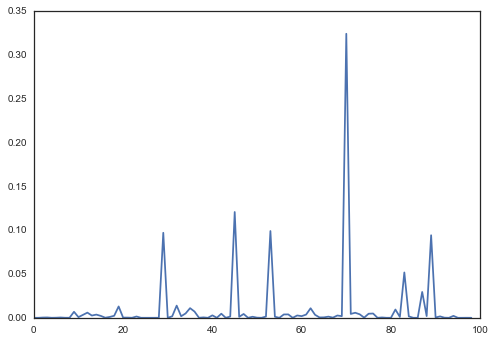

In [38]:
plt.plot(mdl.feature_importances_)

Can we extract which positions' pKa values are associated with a high drug resistance?

## Conclusions

With the Random Forest Regressor, using pKa values as sequence features, we can successfully predict the virus' drug resistance with an average of 1 drug resistance value error.